# How Data Clustering Works

In this notebook we will review the various clustering methods used in the Zooniverse's data aggregation code.  To provide a comprehensive review of the topic, we will begin by covering some of the theory behind data clustering along side some worked examples.  Specifically we will be covering how DBSCAN, OPTICS, and HDBSCAN work, when each should be used, and the various parameters that each of them provide.

## What problem does clustering solve?

At the most basic level, clustering is the process of taking a set of data (e.g. a list of numbers, points drawn on an image, etc...), finding groups of the data that are "similar," and assigning a label to each group.  Once each group is found, an average is used (or a generalization of the average as seen later on) to represent the group with a single value, and the variance about that average is used to define the extent of the group.

### What does it mean to be "similar?"

Two data points are similar if they are close together under some definition of "distance" called a **metric**.  Examples of common metrics are:
- Euclidean distance (i.e. straight line distance)
- Manhattan distance (i.e. you can only move on a fixed grid)
- Jaccard distance (i.e. percent overlap of shapes)
- Most anything you can quantify (e.g. things similar in color, the "roundness" of a shape)
- A combination of multiple metrics

#### Mathematical side note
Mathematically a metric must satisfy three conditions
1. A point always has a distance of zero with itself and any two points with a distance of zero are the same point
2. Distances are symmetric between any two points
3. Distances follow the triangle inequality

See https://en.wikipedia.org/wiki/Metric_(mathematics) for more a detailed definition

### We have distances, now what?

To turn these distances into clusters there are typically two ways to go about it:
- If you know how many cluster there are in the data
  - Find the optimal way to split all the data into N groups such that the pairwise distances between points in each group are as small as possible (e.g. K-means, K-medians, K-centers)
- If you don't know the number of clusters
  - Look for areas in the data with "high density" and assign a group label to each of them (e.g. DBSCAN, OPTICS, HDBSCAN)

For the rest of this notebook we will focus on the second type of clustering since the number of clusters is typically the question Zooinverse projects are trying to answer in the first place.

## Turning density into clusters

In this section we will start diving into to specifics of how DBSCAN, OPTICS, and HDBSCAN work under the hood.  To show this off better we will crete a test set of data we can use for creating visualizations for each step of the process.

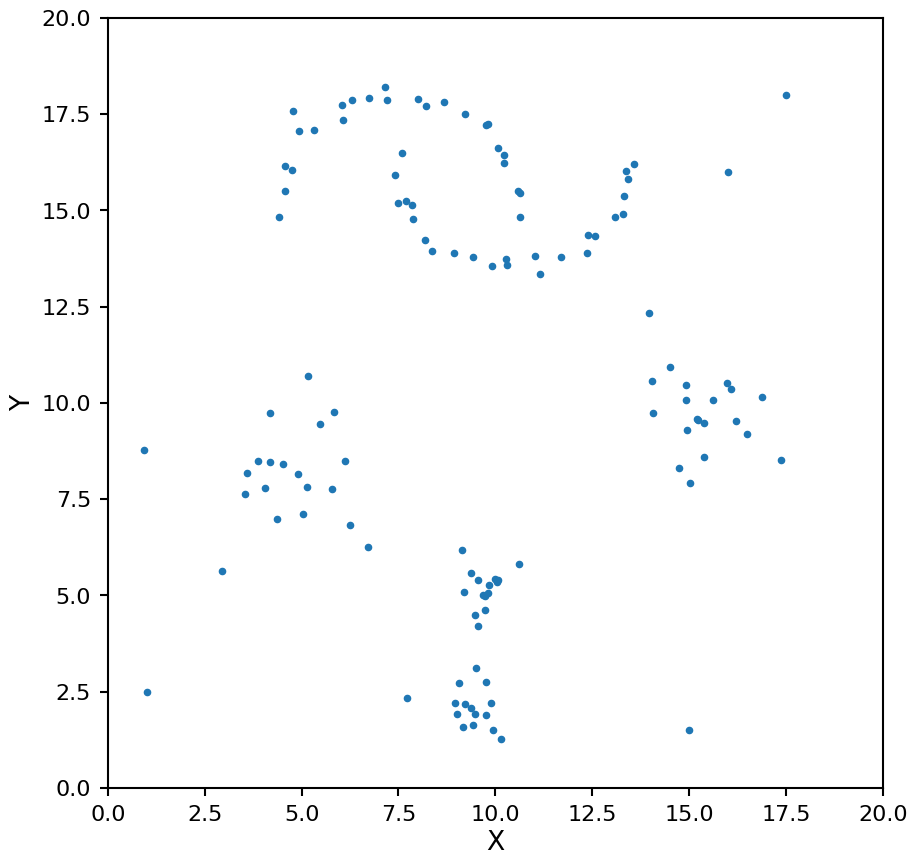

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN
from sklearn.datasets import make_blobs, make_moons

plt.style.use({
    'font.size': 16.0,
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'axes.linewidth': 1.5,
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'axes.spines.top': True,
    'axes.spines.right': True,
})

# Generate sample data
centers_1 = [[9, 2], [10, 5.2]]
X_blob_1, _ = make_blobs(n_samples=30, centers=centers_1, cluster_std=0.5, random_state=0)

centers_2 = [[4, 8], [16, 10]]
X_blob_2, _ = make_blobs(n_samples=40, centers=centers_2, cluster_std=1.2, random_state=0)


X_moons, _ = make_moons(n_samples=50, noise=0.07, random_state=5)
# shift the moons data
X_moons[:, 0] = 3 * (X_moons[:, 0] + 2.5)
X_moons[:, 1] = 3 * (X_moons[:, 1] + 5)

X_noise = np.array([
    [16, 16],
    [17.5, 18],
    [1, 2.5],
    [15, 1.5]
])

# stack all data into one array
X = np.vstack([X_blob_1, X_moons, X_blob_2, X_noise])

# plot data
plt.figure(figsize=[10, 10])
plt.scatter(X[:, 0], X[:, 1], s=20)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('X')
plt.ylabel('Y');

A few notes about the test data here:
- We have blobs of different densities
- We have irregular shaped clusters at the top of the image

These properties will help to distinguish between the clustering methods later on

### Density-based spatial clustering of applications with noise (DBSCAN)

Most density clustering algorithms are rooted in DBSCAN, so as a starting point it is useful to understand how DBSCAN works.  This algorithm is a four step process:
1. **Core points** are defined as a group of at least **k** points (also called **min_samples**) that are all mutually with in a distance $\epsilon$ (also called **eps**) of each other
2. Each set of **core points** is assigned a cluster ID number
3. Any data point that is within a distance $\epsilon$ of any **core point** is assigned the same cluster ID number as that **core point**
4. All other points are marked a noise

Lets see how this works on the test data:

In [2]:
# define a plotting function that will be reused for DBSCAN plots
def plot_dbscan(db, X):
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y');

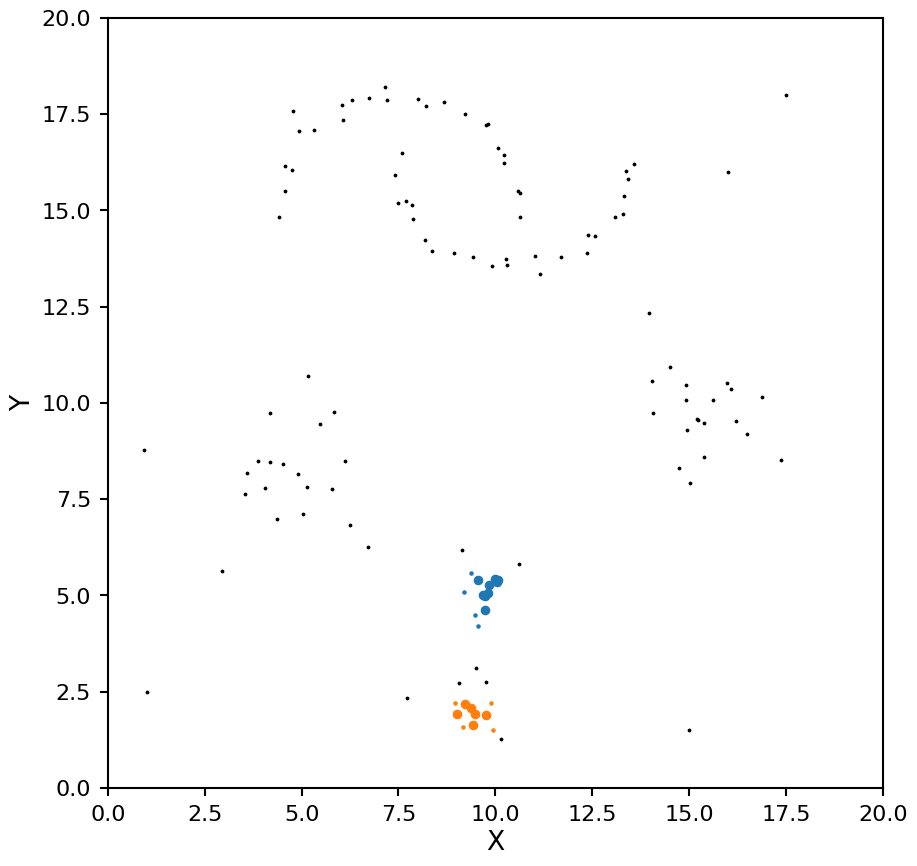

In [3]:
# define parameters
db = DBSCAN(eps=0.5, min_samples=5)

# fit to the data
db.fit(X)

# plot results
plot_dbscan(db, X)

Notice how with a small $\epsilon$ DBSCAN missed the lower density blobs, lets try that again with a larger value:

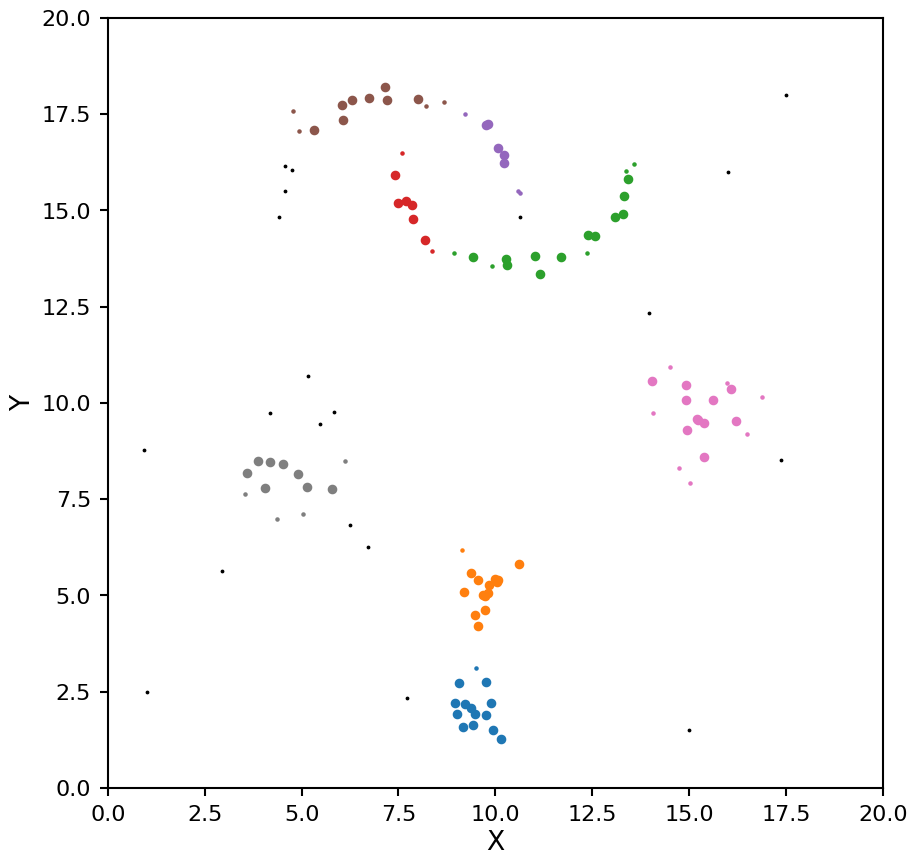

In [4]:
db = DBSCAN(eps=1, min_samples=5)
db.fit(X)
plot_dbscan(db, X)

That is looking a bit better, it is finding all the blobs, but the moons are being split into multiple clusters.  Lets go a bit larger:

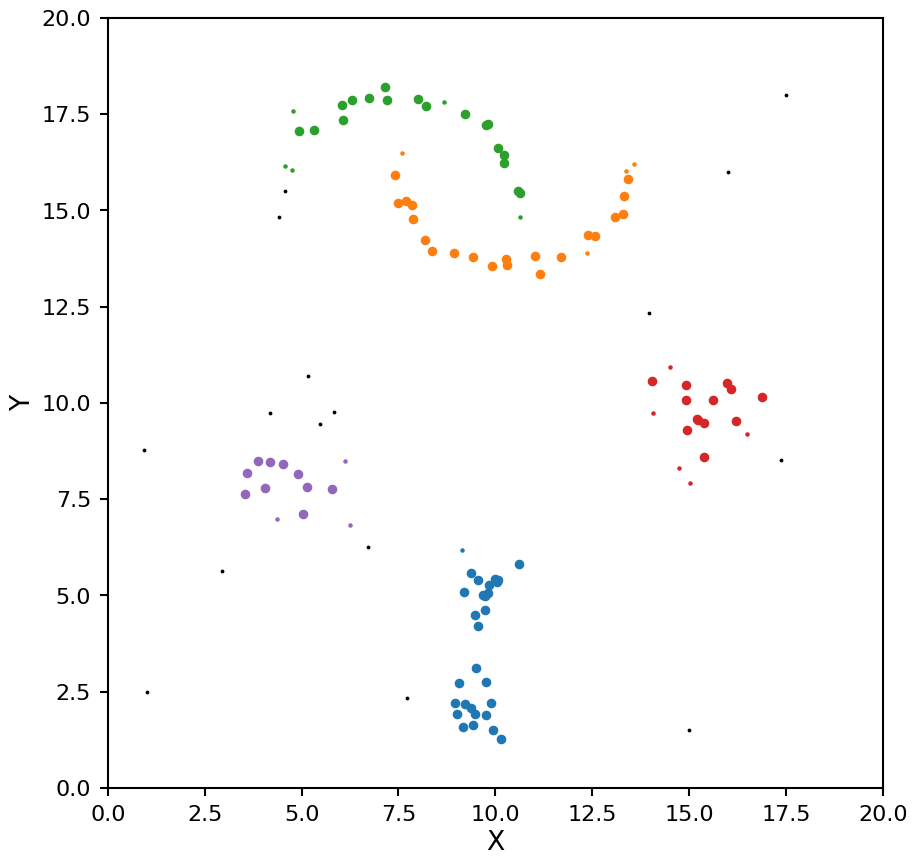

In [5]:
db = DBSCAN(eps=1.1, min_samples=5)
db.fit(X)
plot_dbscan(db, X)

That looks better for the moons, but now the two high density clusters are being seen as one.  This example shows off the main drawback of DBSCAN, it assumes **all clusters in the data have the same density**.

#### Pros and cons of DBSCAN
Pros:
- Easy to write down (both in code and description)
- Can be quite fast on larger data sets
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- Can detect when all points belong to a single cluster

Cons:
- It assumes all clusters in the data have similar densities
- Finding an appropriate $\epsilon$ value cn be difficult and it only gets harder with higher dimensional data

### Improving on DBSCAN
Since its development, the authors of DBSCAN have gone on to generalize the algorithm and come up with news ways to get around its shortcomings.

This lead to the development of OPTICS (ordering points to identify the clustering structure) and HDBSCAN (hierarchial density-based spatial clustering with noise). To better understand how these two algorithms work (and how they relate to DBSCAN) we will define some common terms and techniques.

## Transforming the metric space
To include density information into the clustering process we need to use a metric that includes this density in its calculation.  To make this new metric easier to understand we will introduce some notation:

- $d(a,b)$: the distance between points $a$ and $b$ using the original metric $d$
- $\mathrm{core}_k(a)$: the **core distance** about the point $a$ defined as the distance between point $a$ and its $k^{th}$ nearest neighbor (this value of $k$ is the **min_samples** from before)

The new metric is called the mutual reachability distance (MRD) and is defined as:

$d_{\mathrm{mreach-k}}(a,b) = \max(\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b))$

By using this transformation the distance between points in high density areas (with low core distances) are unchanged, and the distance between points in low density areas (high core distances) are increased.

### Note about the MRD
The above equation is the MRD as defined by HDBSCAN, OPTICS uses a slightly different definition for its MRD.  While the function is different, in the has the same effect on the data points as the equation above, high density points stays the same and low density points are "pushed away".

### Example
Let's take a look at how this new metric transforms the data points in our test set.  Note, the following code is only for illustrating what this process does, in production this transformation is done by the OPTICS and HDBSCAN internally.  After finding the MRD we can use multi-dimensional scaling (MDS) to visualize what the points would look like with these new distances.

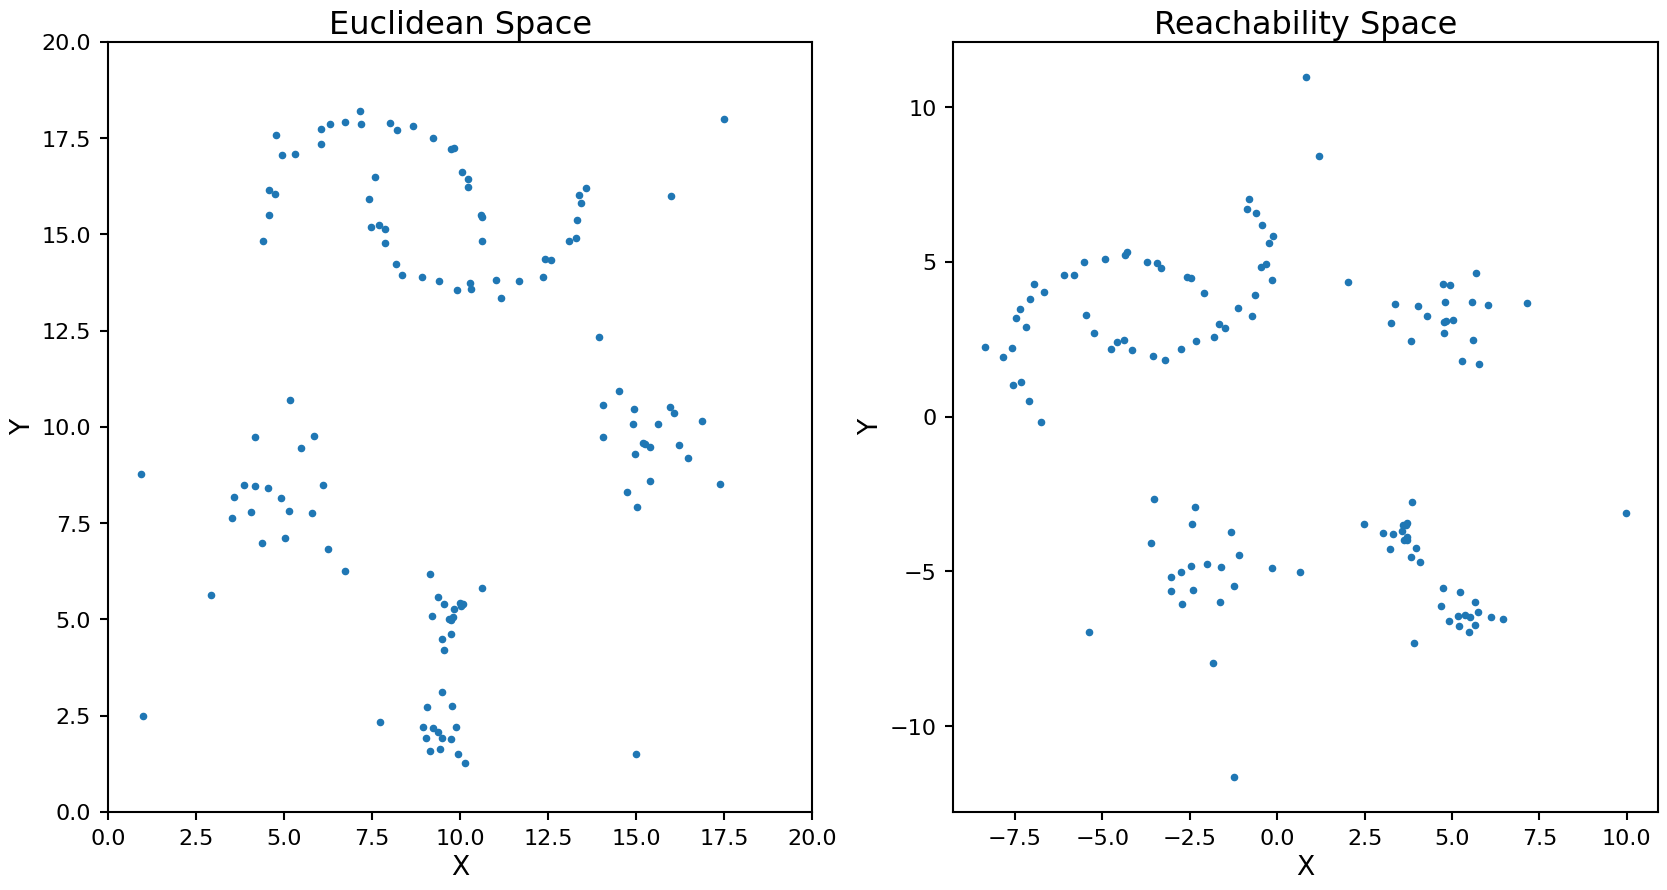

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import euclidean_distances
from sklearn import manifold

k = 5

# use k+1 as the nearest neighbor will always be the point itself
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
distances, _ = nbrs.kneighbors(X)

# the core distance for each point
core_k = distances[:, -1]

# max of core distances pair-wise
core_k_outer = np.maximum.outer(core_k, core_k)

# distance matrix for original metric
d = euclidean_distances(X)

# distance matrix for the mutual reachability metric
d_mreach = np.maximum(d, core_k_outer)

# use Multi-dimensional scaling to transfrom data points to have the distances for the new metric
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', n_jobs=1, random_state=4)
pos = mds.fit(d_mreach).embedding_

plt.figure(figsize=[20, 10])


ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], X[:, 1], s=20)
ax1.set_xlim(0, 20)
ax1.set_ylim(0, 20)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Euclidean Space')

ax2 = plt.subplot(122)
ax2.scatter(pos[:, 0], pos[:, 1], s=20)
ax2.set_xlabel('X')
ax2.set_ylabel('Y');
ax2.set_title('Reachability Space');

The rotation and translation of the transformed points is random as the MDS process does not have a unique solution.

## Minimum spanning tree and Reachability plot
Now that we have the MRD matrix we can use that data to create a minimum spanning tree.  This is a process of connecting every data point in the set to at least one other point such that the sum of MRD values for each connection is minimized across the entire data set.  Doing this provides a way to order the data points.

Let's construct the minimum spanning tree for our test data.  The links are color coded by the MRD value between the connected points.

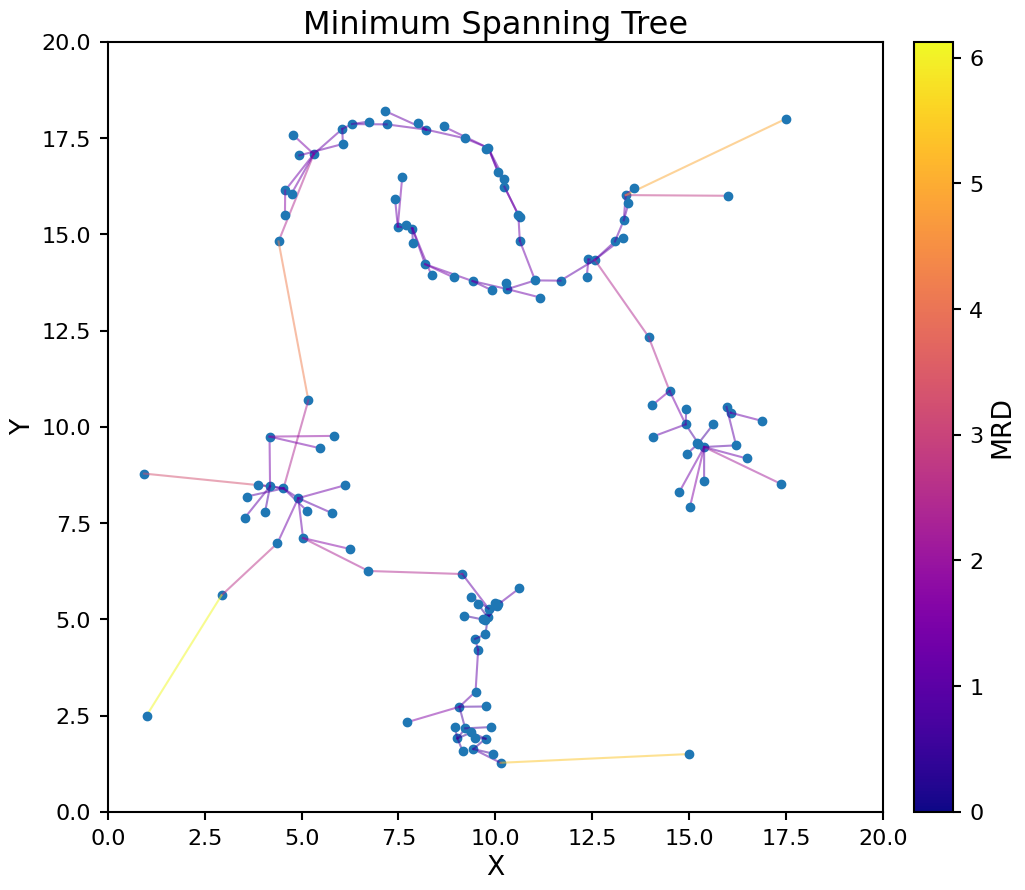

In [10]:
from scipy.sparse.csgraph import minimum_spanning_tree
from matplotlib import cm, colors, colorbar, colormaps

mst = minimum_spanning_tree(d_mreach).toarray()

# Normalise the colourbar to the data
norm = colors.Normalize(vmin=mst.min(), vmax=mst.max())
cmap = colormaps.get_cmap('plasma')

plt.figure(figsize=[10, 10])
ax = plt.gca()
for i in range(X.shape[0]):
    plt.plot(X[i, 0], X[i, 1], 'o', color='C0')
    for j in mst[i].nonzero()[0]:
        color = cmap(norm(mst[i, j]))
        plt.plot(X[[i, j], 0], X[[i, j], 1], '-', color=color, alpha=0.5)

# colorbar
cax = ax.inset_axes([1.04, 0.0, 0.05, 1], transform=ax.transAxes)
cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_label('MRD')

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Minimum Spanning Tree');

Starting from the minimum spanning tree, we can creates a reachability plot to better understand the data's structure.  This plots the MRD for each point in the tree ordered by how the tree connects the points.

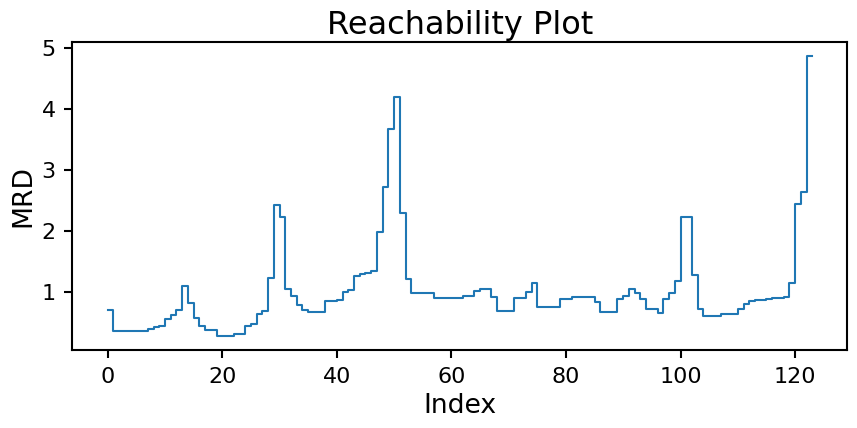

In [11]:
# for consistency with the next section we will use OPTICS to make the spanning tree this time
opt = OPTICS(min_samples=5)
opt.fit(X)

space = np.arange(X.shape[0])
reachability = opt.reachability_[opt.ordering_]

plt.figure(figsize=[10, 4])
plt.step(space, reachability)
plt.xlabel('Index')
plt.ylabel('MRD')
plt.title('Reachability Plot');

From the plot we can start to see a distinct "U" pattern caused by the clustered nature of the data.  When you pass from one cluster to the next the MRD value will increase rapidly, but when you are within a cluster it stays more consistent.  

### DBSCAN again
All of this work now gives us a second way to compute clusters for DBSCAN.  Drawing horizontal lines at the desired $\epsilon$ value and taking all continuous groups of points below the line to be a single cluster gives us back the DBSCAN results from before!  Here is the reachability plot again with the $\epsilon$ values from above:

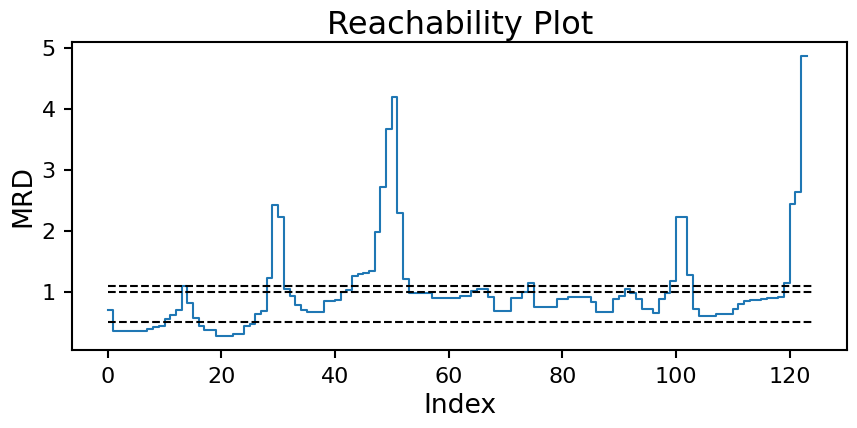

In [12]:
plt.figure(figsize=[10, 4])
plt.step(space, reachability)

plt.hlines([0.5, 1.0, 1.1], xmin=0, xmax=X.shape[0], ls='--', color='k')

plt.xlabel('Index')
plt.ylabel('MRD')
plt.title('Reachability Plot');

Now we can see the issue we where having coming up with a good $\epsilon$ value more clearly.  The moon clusters are quite shallow in reachability (approx. index 50 to 100).  Setting a horizontal line that splits the moons into two clusters (edge at approx. index 75) will necessarily cause the two high density clusters (edge at approx. index 15) to be combine into one.  With multiple densities at play, a single horizontal line will never work.

### OPTICS to the rescue

OPTICS looks at the slope from one point to the next on this plot and if it passes a threshold value $\xi$ (called **xi** in the code) a cluster boundary is drawn.  In essence this looks for the distinct "U" shape clusters make on this plot.  Specifically, cluster boundaries are drawn if the ratio from one point to its successor on the reachability plot is more than $1 - \xi$.

In general you are better off keeping $\xi$ at its default value of 0.05 and instead adjust **min_samples** as it will have a more meaningful effect on the resulting clusters.

Time to look at some examples:

In [13]:
# defind a plotting function that will be reused for OPTICS plots

def plot_optics(opt, X):
    space = np.arange(X.shape[0])
    reachability = opt.reachability_[opt.ordering_]

    fig = plt.figure(figsize=(10, 13))
    gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), hspace=0.07)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    unique_labels = set(opt.labels_)
    labels = opt.labels_[opt.ordering_]
    for k in unique_labels:
        kdx1 = labels == k
        kdx2 = opt.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            s=3
            
        else:
            color = f'C{k}'
            s=15
        ax2.scatter(X[kdx2, 0], X[kdx2, 1], color=color, s=s)
        ax1.scatter(space[kdx1], reachability[kdx1], color=color, s=s)

    ax2.set_xlim(0, 20)
    ax2.set_ylim(0, 20)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y');

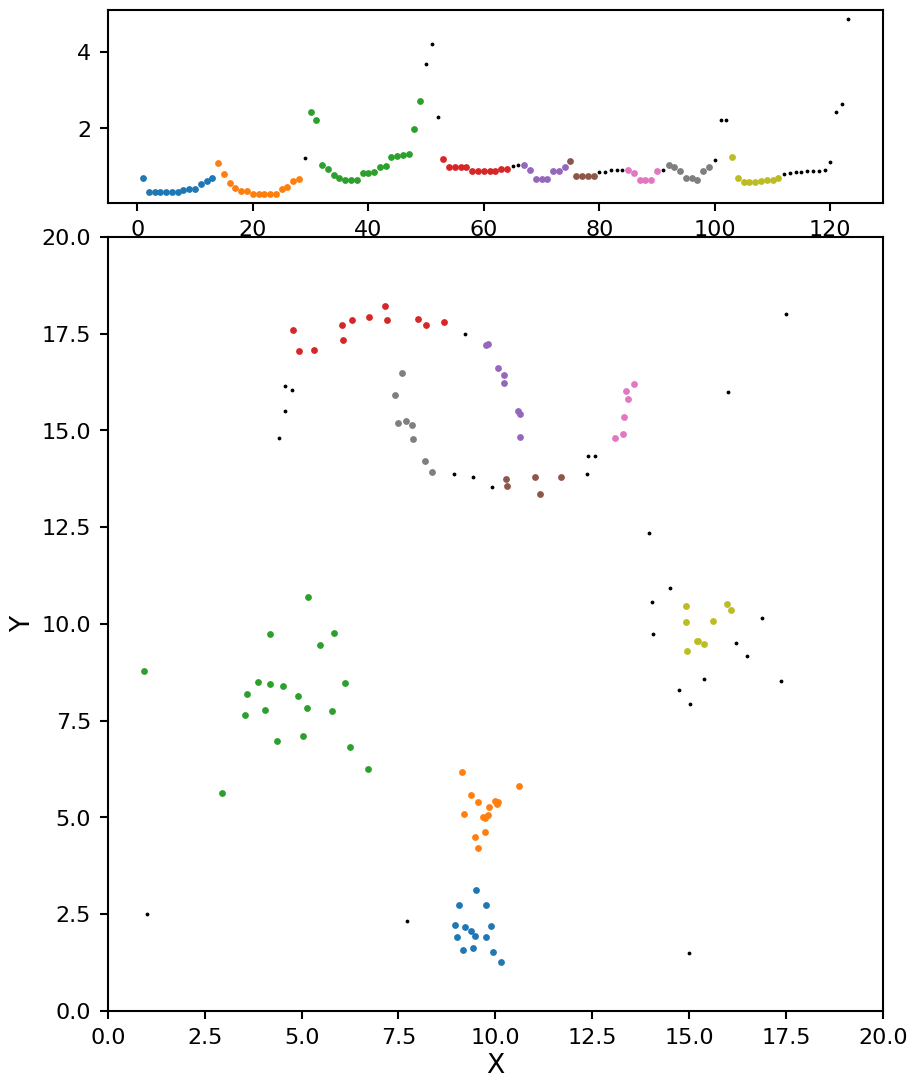

In [14]:
opt = OPTICS(min_samples=5)
opt.fit(X)

plot_optics(opt, X)

With **min_samples** set to 5 we see OPTICS does a decent job of pulling out the blob clusters, but it splits the moon clusters in to too many sections.  At this point you could start adjust the $\xi$ value, but that will have a minimal impact on the results and can be quite tricky to set.  Instead let's adjust **min_samples** to a higher value of 7:

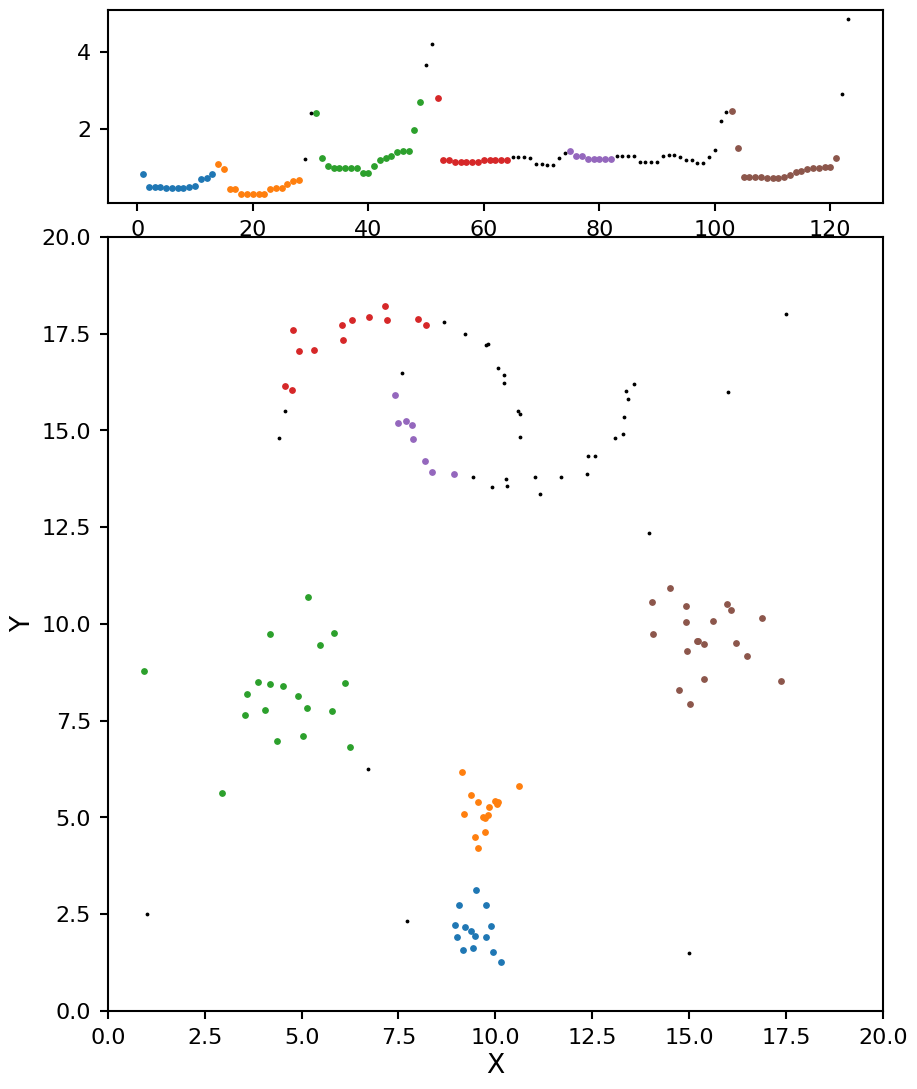

In [15]:
opt = OPTICS(min_samples=7)
opt.fit(X)

plot_optics(opt, X)

This is looking more promising, there are two clusters for the moons, and four clusters for the blobs.  The only issue now is the moon clusters are a bit on the small side.  There is one more parameter we can adjust to help with this called **min_cluster_size**.  As the name suggests, it will grow each cluster (based on the spanning tree connections) until they each have at least this number of points.

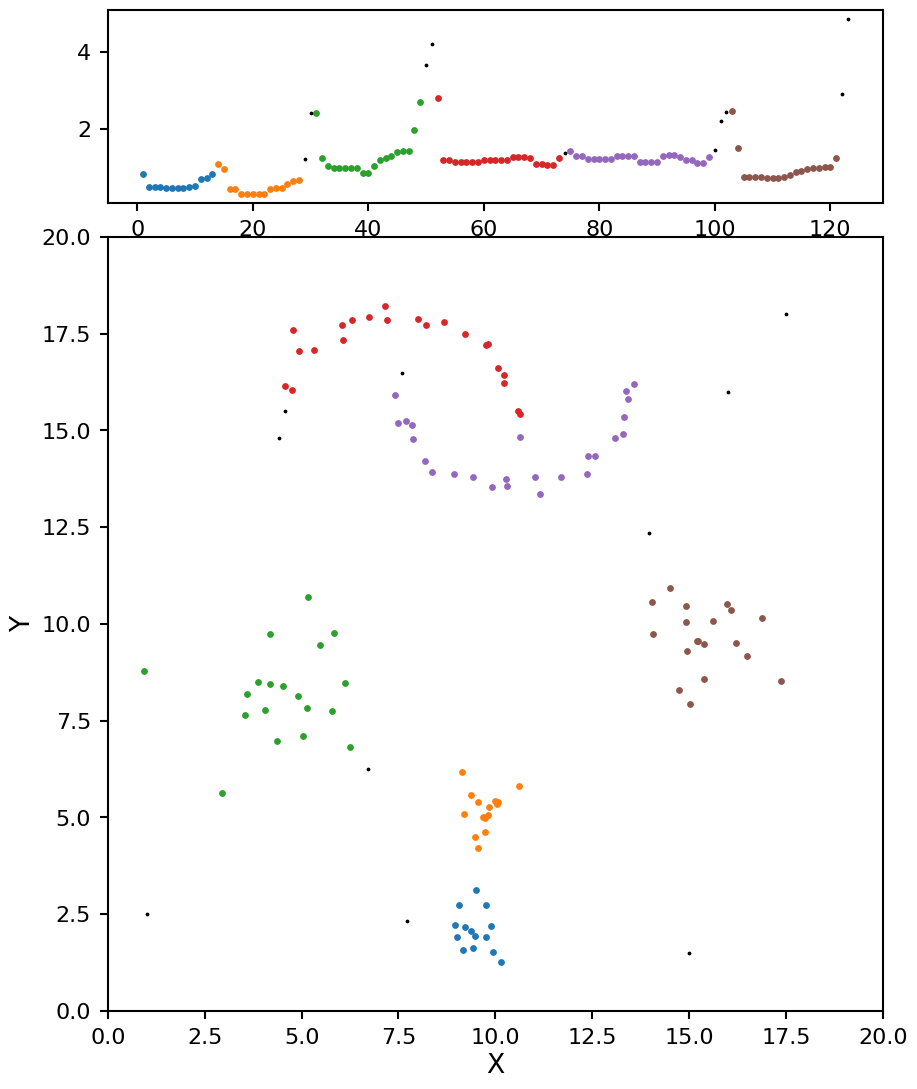

In [16]:
opt = OPTICS(min_samples=7, min_cluster_size=14)
opt.fit(X)

plot_optics(opt, X)

Now these results look even better, and very close the the ground truth values.

#### Pros and cons of OPTICS
Pros:
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- Can detect when all points belong to a single cluster
- All clusters can be different densities

Cons:
- Not easy to write down (in code or description)
- Can take longer to run and use more memory than DBSCAN or HDBSCAN for large data sets

### HDBSCAN
For HDBSCAN lets go back to the minimum spanning tree from before:

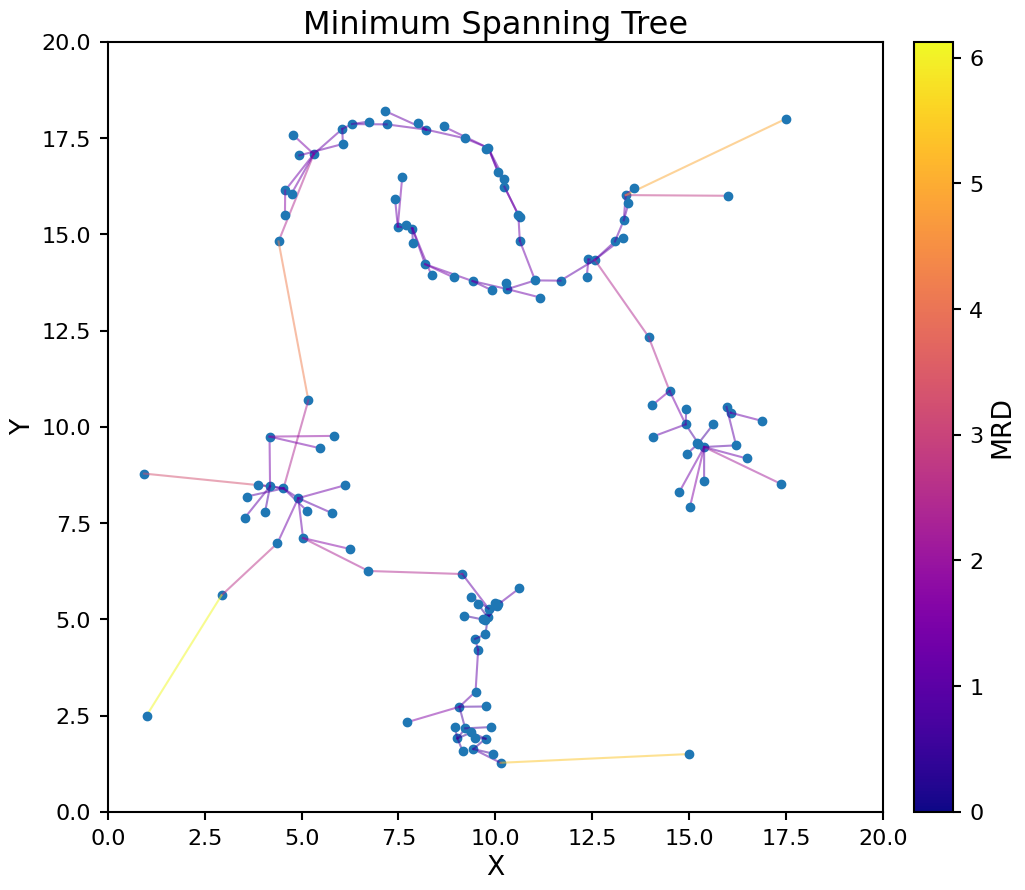

In [17]:
from scipy.sparse.csgraph import minimum_spanning_tree
from matplotlib import cm, colors, colorbar, colormaps

mst = minimum_spanning_tree(d_mreach).toarray()

# Normalise the colourbar to the data
norm = colors.Normalize(vmin=mst.min(), vmax=mst.max())
cmap = colormaps.get_cmap('plasma')

plt.figure(figsize=[10, 10])
ax = plt.gca()
for i in range(X.shape[0]):
    plt.plot(X[i, 0], X[i, 1], 'o', color='C0')
    for j in mst[i].nonzero()[0]:
        color = cmap(norm(mst[i, j]))
        plt.plot(X[[i, j], 0], X[[i, j], 1], '-', color=color, alpha=0.5)

# colorbar
cax = ax.inset_axes([1.04, 0.0, 0.05, 1], transform=ax.transAxes)
cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_label('MRD')

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Minimum Spanning Tree');

HDBSCAN does the follow:

0. Set $\lambda$ to 0
1. Start with all the points in a single cluster
2. Find the largest link in the spanning tree and remove it
3. Count the number of points in each distinct set of linked points, if it is above a threshold value (called **min_cluster_size**) keep the cluster and track the size, if not remove the cluster.
4. Increase $\lambda$ by 1/distance for the link that was cut
5. For each distinct set of linked points repeat steps 1-4, continue until all points are removed

See [John Healy's talk](https://www.youtube.com/watch?v=dGsxd67IFiU) on HDBSCAN for more details.

By encoding the number of points in each clusters at each $\lambda$ values as the thickness of of the bar on tree plot we can create what is called the condensed tree plot. The HDBSCAN algorithm used in `panoptes_aggregation` from `scikit-learn` does not have this functionality however. But these plots can be generated using the original [HDBSCAN package](https://github.com/scikit-learn-contrib/hdbscan/tree/master), and are reproduced below for illustration.

![GUI](_static/condensed_tree_plot.png)

#### Picking out the clusters

This condensed tree plot can be used to find the most "long lived" clusters by finding the bars on this plot that contain the most "surface area."  (Although it might not look like it, the area of each bar on this plot is directly proportional to the probability of each cluster being the "true" cluster).  This is refereed to as the Excess of Mass (eom) method of selecting clusters.  We can circle these selected clusters by using the **select_clusters** keyword when plotting using the original HDBSCAN.

This plot is reproduced below.

![GUI](_static/condensed_tree_plot_clusters_shown.png)

Now let's look at the clusters identified by HDBSCAN.

In [39]:
# defind a plotting function that will be reused for HDBSCAN plots
def plot_hdbscan(db, X):
    fig = plt.figure(figsize=(10, 10))

    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=10)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y')

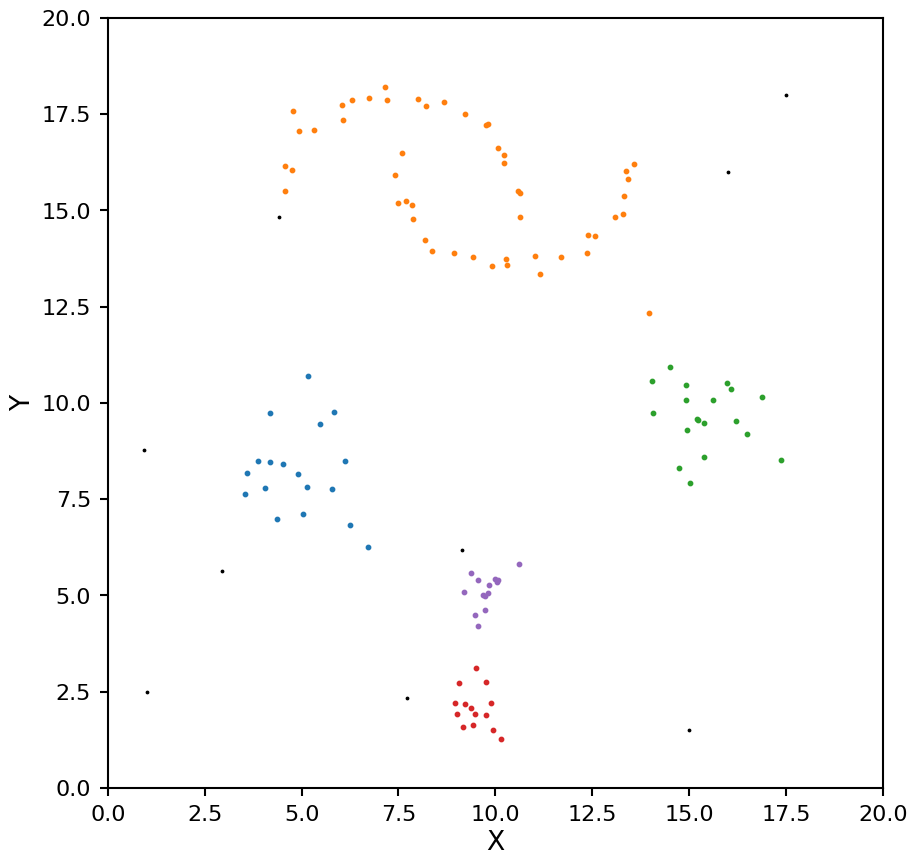

In [40]:
hdb = HDBSCAN(min_samples=5)
hdb.fit(X)

plot_hdbscan(hdb, X)

HDBSCAN was able to find the blobs easy enough, but the two moons are being seen as a single cluster.  Let's try a different **min_samples**.

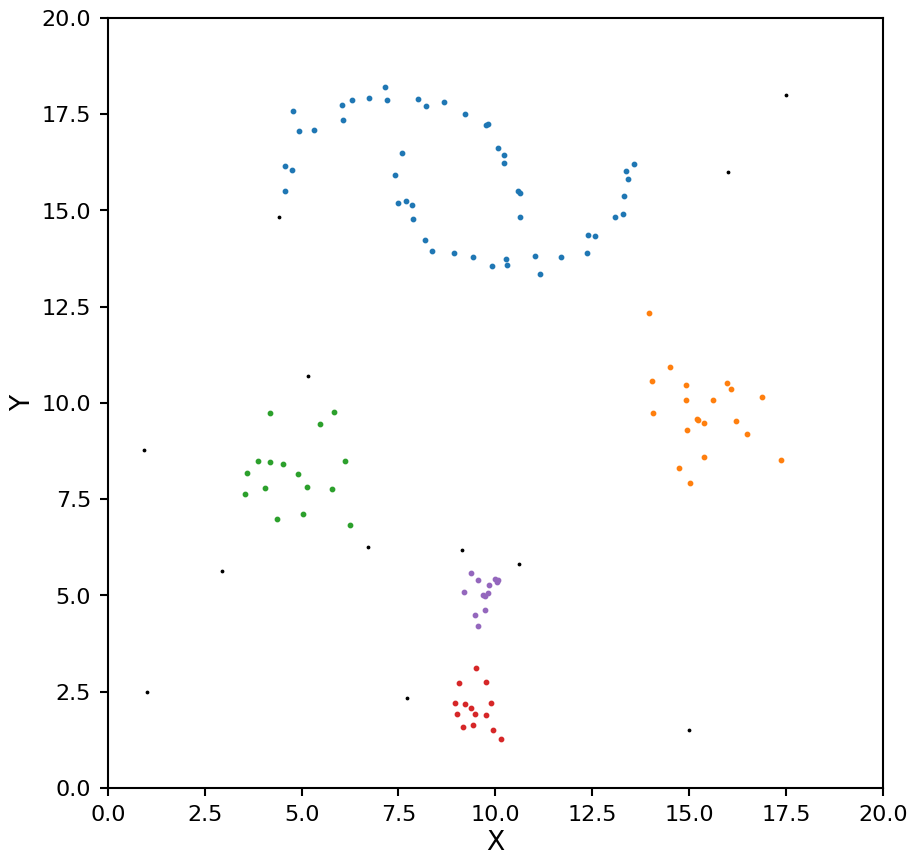

In [41]:
hdb = HDBSCAN(min_samples=7)
hdb.fit(X)

plot_hdbscan(hdb, X)

Aside from changing the order of the clusters labels, the clusters are identical. Again the two moons are a single cluster.  This shows one of one of the limitations of selecting clusters using eom; it tends to find larger clusters.  If you need a larger number of clusters you can change the **cluster_selection_method** keyword from "eom" to "leaf".

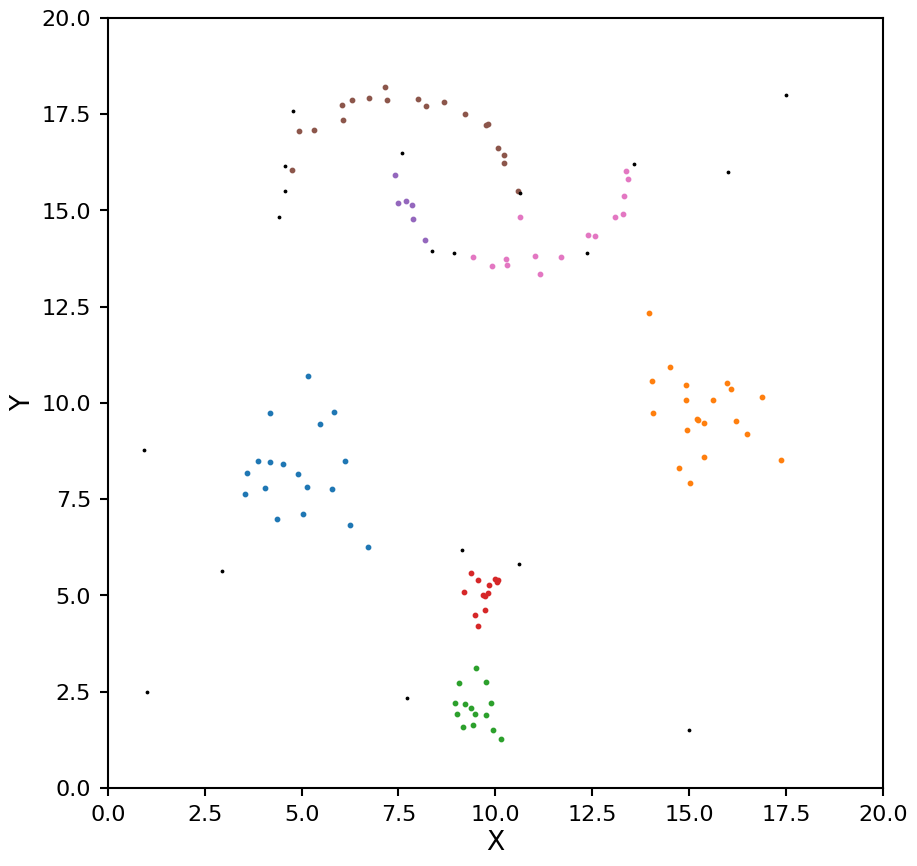

In [26]:
hdb = HDBSCAN(min_samples=6, cluster_selection_method="leaf")
hdb.fit(X)

plot_hdbscan(hdb, X)

As with OPTICS we now see the moons being split into too many clusters.  We can help mitigate this by setting the **min_cluster_size** keyword (by default **min_samples** and **min_cluster_size** are the same value).

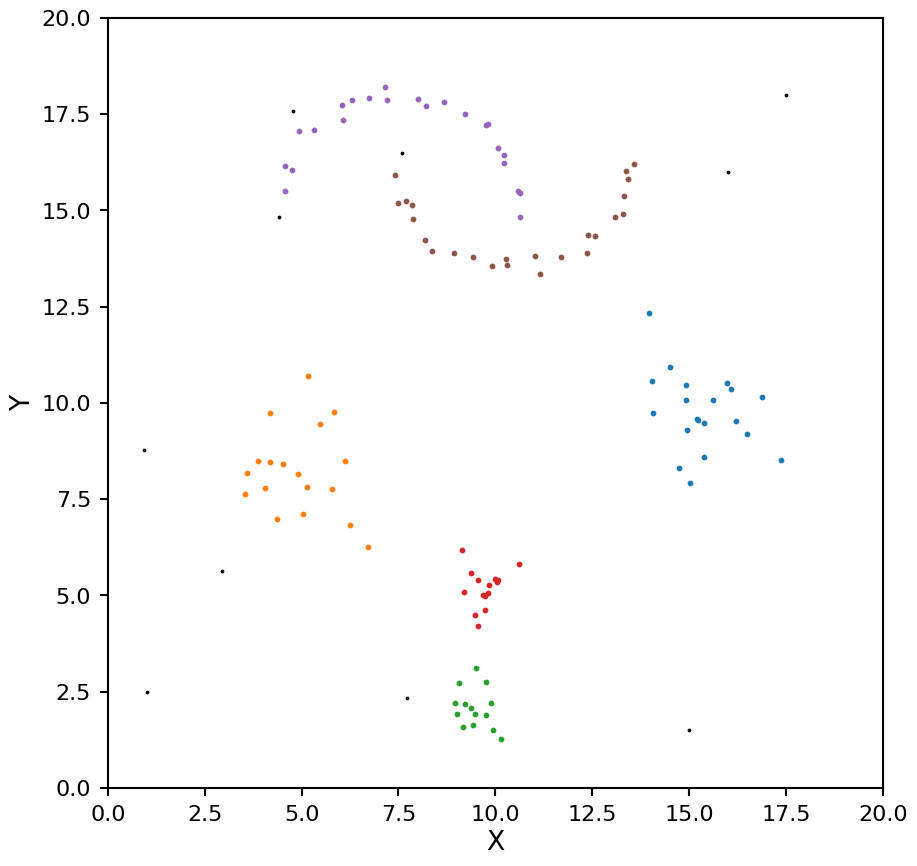

In [28]:
hdb = HDBSCAN(min_samples=4, min_cluster_size=8, cluster_selection_method="leaf")
hdb.fit(X)

plot_hdbscan(hdb, X)

Now these clusters look much closer to the true values.

### What if there is only one cluster in the data?

This is one case where HDBSCAN does not do so well.  Because of the way the algorithm constructs the condensed tree, the top leaf (representing all the data points belonging to a single cluster) will tend to be picked even when there are clear structures in the data, for this reason it will ignore this case by default.  If you do want to consider all the data belonging to a single cluster as a valid solution you can set the **allow_single_cluster** keyword.  Below we can illustrate this by setting **min_samples** to 10 with **allow_single_cluster** both on and off.

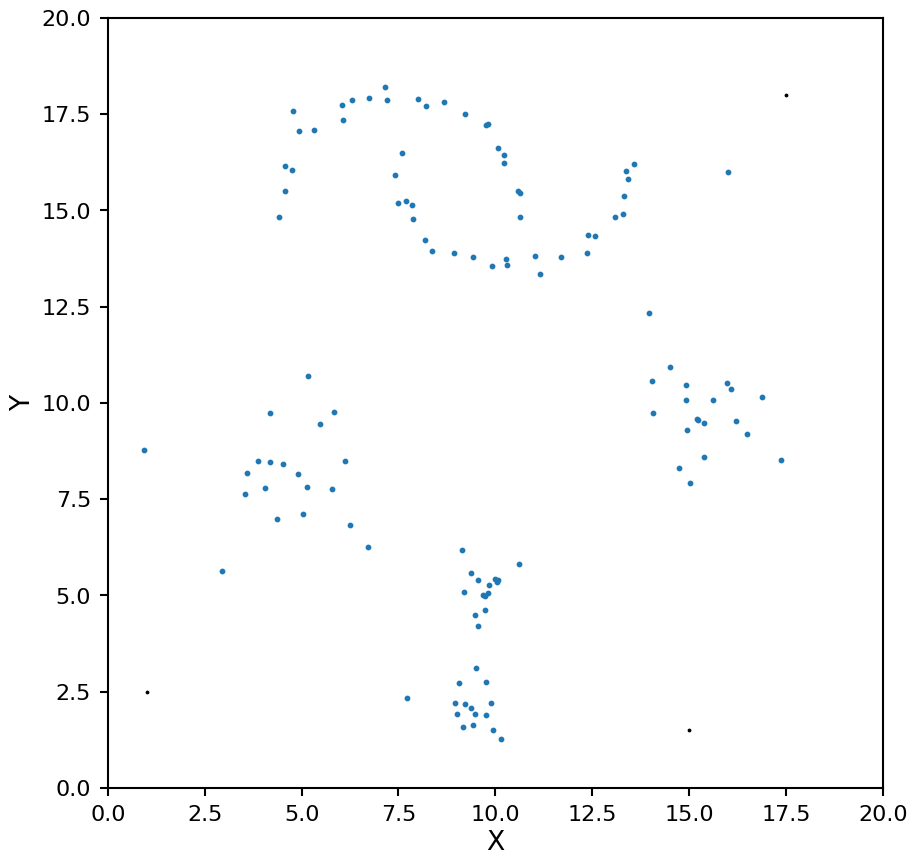

In [31]:
hdb = HDBSCAN(min_samples=10, allow_single_cluster=True)
hdb.fit(X)

plot_hdbscan(hdb, X)

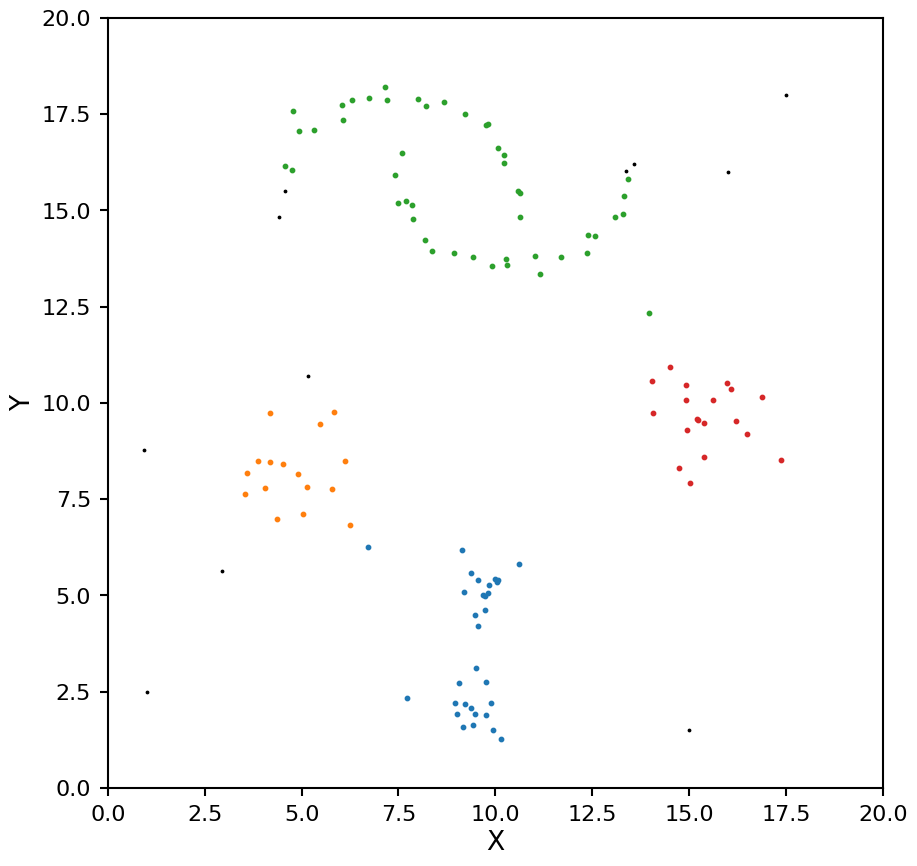

In [32]:
hdb = HDBSCAN(min_samples=10, allow_single_cluster=False)
hdb.fit(X)

plot_hdbscan(hdb, X)

#### Pros and cons of HDBSACN
Pros:
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- All clusters can be different densities
- Probabilities for each point belonging to a cluster are given
- Stability for each cluster is given

Cons:
- Can't detect when all points belong to a single cluster by default
- The smallest cluster must have at least two points

## How does panoptes-aggregation use clustering?

Withing the panoptes-aggregation packages several different clustering methods are available for various task types.

Most drawing tasks have DBSCAN, OPTICS, and HDBSCAN available.  The metric used for each shape is
- Full Height Line: $d = |x_1 - x_2|$ (1D Euclidean)
- Full Width Line: $d = |y_1 - y_2|$ (1D Euclidean)
- Point: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$ (2D Euclidean)
- Column: $d = \sqrt{(x_{1, start} - x_{2, start})^2 + (x_{1, end} - x_{2, end})^2}$ (2D Euclidean)
- Circle: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (r_1 - r_2)^3}$ (3D Euclidean)
- Rectangle: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (l_1 - l_2)^2 + (w_1 - w_2)^2}$ (4D Euclidean)
- Line: $d = \sqrt{(x_{1, start} - x_{2, start})^2 + (y_{1, start} - y_{2, start})^2 + (x_{1, end} - x_{2, end})^2 + (y_{1, end} - y_{2, end})^2}$ (4D Euclidean)

For the rotating tools we need to introduce a separate metric for measuring differences in the angle.  Let $d_\theta$ be the difference between the angles computed in degrees.  

If the **symmetric** keyword is set on the reducer the wrap around angle for this distance can be adjusted so for example a rectangle at 0 degrees and 180 degrees have a distance of zero.  The wrap around angle is tailored to the shape in question, 180 degrees for rectangle and ellipse, 120 degrees for triangle, and 360 degrees for the fan.  The Line reducer can also use the **symmetric** keyword, although in this case it orients both lines as if they were drawn from left to right before clustering as the angle of the line is not directly used in the metric above.  If the **symmetric** keyword is not set the wrap around angle is taken to be 360 degrees for any of these shapes.

- Triangle: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (r_1 - r_2)^3 + d_\theta^2}$ (3D Euclidean + 1D angle)
- Rotating Rectangle: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (l_1 - l_2)^2 + (w_1 - w_2)^2 + d_\theta^2}$ (4D Euclidean + 1D angle)
- Ellipse: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (ry_1 - ry_2)^2 + (rx_1 - rx_2)^2 + d_\theta^2}$ (4D Euclidean + 1D angle)
- Fan: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (r_1 - r_2)^2 + (s_1 - s_2)^2 + d_\theta^2}$ (4D Euclidean + 1D angle)

Averages of for each shape are taken to be the typical mean of each of the input parameters for all points belonging to each cluster.  Similarly the standard deviation is provided for each parameter.

As the polygon and freehand line tools are not parametrized they don't fit nicely into this kind of clustering analysis.

The transcription tools are a special case that uses additional information about how text is presented on a page to better define the clustering.  There are two modes available, DBSCAN used in a 3x1D clustering configuration (fist cluster by angle, followed by line, followed by word), or OPTICS using the 4D line metric above.  Additional checks are added to avoid "self clustering" that can happen when one classification has two lines that are close together.

### Drawbacks to these metrics

There are a few drawbacks to using these Euclidean based metrics:

- For any of the metrics with more than 2 dimensions it becomes difficult to identify the best $\epsilon$, and often it comes down to trial and error on example data to find a value that works
- Distances are in image pixels, so clustering is dependent on the size of the shapes drawn and resolution of the uploaded subjects
- For the rotating shapes a change of 1 degree is given the same weight as a change in one pixel, given the extent of the shape this might not be the most accurate weighting to use

## Is there a better metric?

Given the shortcomings listed above, let's see how a non-Euclidean metric would work.  Specifically, we will look at the Jaccard metric that defines the distance between to **closed** shapes to be:

$d = 1 - \frac{|A \cap B|}{|A \cup B|}$

Or in words, one minus the ration of the intersection area to the union area of the two shapes.  If both shapes are the same this distance becomes zero, and if they don't overlap at all this distance is one.

### Strengths of this metric

- It is independent of the size of the shapes being clustered
- It is independent of the size of the underlying images the shapes were drawn on
- Any rotationally symmetries are automatically taken into account

### Drawbacks of this metric

- It takes more work to define an average shape once a cluster is found (see the next section for this work)
- After finding an average the variance on that average is difficult to interpret (see next section for some special cases where we can make some headway)
- Distances take a bit longer to compute (although for small sample sizes it is not that noticeable)
- Only works for closed shapes with no self-intersections

### How do you find the average in a general metric space?

What does it mean to take an average value?  The goal is to find a point that minimizes the distance to all the points in your dataset.  Specifically, it minimizes the Fréchet variance:

$\Psi(p) = \sum_{i=1}^{N} d^{2}(p, x_i)$

where $x_i$ is the set of data points being averaged and $d$ is the metric being used to calculate the distance.

If you plug in the standard Euclidean metric into the above equation and minimize with respect to $p$ you will find the standard equation for an average.  When we are using the Jaccard metric for clustering we will also have to use the same metric when finding an average shape for each cluster.  There is no clean analytic form for the average when using the Jaccard metric, but we can still find the minimum numerically (specifically [scipy.optimize.shgo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html) is used with appropriate bounds placed on all the shape parameters).


#### Mathematical side note

If you replace $d^2$ with $|d|$ the resulting minimization will produce the median rather than the average.  While it might be tempting to use the median to be more robust to outliers, it is not needed in this case as the clustering step proceeding this average has already removed any outliers from the cluster.

### Interpreting the variance

The variance on the average is just the value of the Fréchet variance at the minimum point.  A 1-$\sigma$ confidence region is defined as the set of points that are a distance of $\sqrt{\Psi(\bar{x})}$ from the average point $\bar{x}$.  For the Euclidean metric this can be done independently for each of the shape parameters, but for the Jaccard metric it is a bit more complex.

The Jaccard distance between two shapes can be changed through translations, rotations, scaling, or a any combination of the three.  The confidence regions resulting from pure translations or rotations are shape dependent, but for pure scaling it becomes independent of the drawn shapes.  For this reason we will focus on the case of pure scaling.

Let $\gamma$ be the scaling factor for the average shape.  If $\gamma$ is less than 1 the shape becomes smaller and the Jaccard distance for 1-$\sigma$ is:

$\sigma = 1 - \frac{\gamma^2 * A}{A} = 1 - \gamma^2 \Rightarrow \gamma = \sqrt{1 - \sigma}$

Where $A$ is the area of the shape.

If $\gamma$ is more tha 1 the shape becomes bigger and the Jaccard distance for 1-$\sigma$ is:

$\sigma = 1 - \frac{A}{\gamma^2 * A} = 1 - \frac{1}{\gamma^2} \Rightarrow \gamma = \frac{1}{\sqrt{1 - \sigma}}$

This gives us a nice way to represent the 1-$\sigma$ confidence region of our average shape by scaling it both up and down by the factor $\sqrt{1 - \sigma}$.

## Examples using panoptes_aggregation

Now that we have covered how the various types of clustering work, let's create some mock zooniverse data and uses the various clustering reducers available in the `panoptes_aggregation` package.  For these examples we will start with the data **after** it has gone through the extraction phase and we will run the functions from directly in python rather than using CSV files (this technically what `panoptes_aggregation` does on a row-by-row bases when you pass the extracted CSV file to the reduction step).  For completeness, we will also show what the reducer configuration file would look like for each example.

### Mock rectangle extracts

The rectangle tool parametrizes the shape into four values, $x$ position of upper left corner, $y$ position of upper left corner, $w$ width, and $h$ height.

In [36]:
import panoptes_aggregation

# raw rectangle paramters
raw_rectangles = np.array([
    [1, 1, 3, 2],
    [0.7, 0.8, 3.1, 2.3],
    [0.75, 0.9, 2.88, 2.1],
    [0.5, 0.5, 8.5, 2.5],
    [5.3, 1, 3, 2],
    [5.0, 0.8, 3.1, 2.3],
    [5.25, 0.9, 2.88, 2.1],
    [3, 1.5, 4, 1],
    [3.04, 3.4, 0.5, 0.5],
    [3.1, 3.5, 0.49, 0.51],
    [2.95, 3.6, 0.51, 0.49],
    [3.05, 3.55, 0.5, 0.5],
]) * 100

# assume each rectangle is a different classification make on `frame0` with tool `T0`
extracted_data = []
for rectangle in raw_rectangles:
    extracted_data.append({
        'frame0': {
            'T0_tool0_x': [rectangle[0]],
            'T0_tool0_y': [rectangle[1]],
            'T0_tool0_width': [rectangle[2]],
            'T0_tool0_height': [rectangle[3]]
        },
        'aggregation_version': panoptes_aggregation.__version__ 
    })

user_id = range(len(raw_rectangles))

ModuleNotFoundError: No module named 'panoptes_aggregation'

In [56]:
from panoptes_aggregation.reducers.shape_metric_IoU import panoptes_to_geometry, sigma_shape

def plot_reduction(reduction):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.gca()

    unique_labels = set(reduction['frame0']['T0_tool0_cluster_labels'])
    extracts = np.vstack((
        reduction['frame0']['T0_tool0_rectangle_x'],
        reduction['frame0']['T0_tool0_rectangle_y'],
        reduction['frame0']['T0_tool0_rectangle_width'],
        reduction['frame0']['T0_tool0_rectangle_height']
    )).T

    # make use of panoptes_aggregation.reducers.shape_metric_IoU.panoptes_to_geometry
    # to convert a list of paramters into shapely geomentry objects

    for k in unique_labels:
        kdx = np.array(reduction['frame0']['T0_tool0_cluster_labels']) == k
        if k == -1:
            # these are the noise points
            color = 'k'
            for rectangle in extracts[kdx]:
                geometry = panoptes_to_geometry(rectangle, 'rectangle')
                plt.plot(*geometry.exterior.xy, lw=1, color='k', ls='--')
        else:
            color = f'C{k}'
            for rectangle in extracts[kdx]:
                geometry = panoptes_to_geometry(rectangle, 'rectangle')
                plt.plot(*geometry.exterior.xy, lw=1, color=color, ls='-')
            avg_rectangle = np.array([
                reduction['frame0']['T0_tool0_clusters_x'][k],
                reduction['frame0']['T0_tool0_clusters_y'][k],
                reduction['frame0']['T0_tool0_clusters_width'][k],
                reduction['frame0']['T0_tool0_clusters_height'][k]
            ])
            avg_geometry = panoptes_to_geometry(avg_rectangle, 'rectangle')
            plt.plot(*avg_geometry.exterior.xy, lw=3, color=color, ls='--')
            if 'T0_tool0_clusters_sigma' in reduction['frame0']:
                # get the 1-sigma scaled up and down shape using gamma factor derived above
                std = reduction['frame0']['T0_tool0_clusters_sigma'][k]
                avg_param_plus, avg_param_minus = sigma_shape(avg_rectangle, 'rectangle', std)
                avg_plus = panoptes_to_geometry(avg_param_plus, 'rectangle')
                avg_minus = panoptes_to_geometry(avg_param_minus, 'rectangle')
            else:
                # estimate the std of each papramter independent of each other
                # not 100% correct way to plot this, but close enough to get an idea
                std = extracts[kdx].std(axis=0)
                avg_plus = panoptes_to_geometry(avg_rectangle + std, 'rectangle')
                avg_minus = panoptes_to_geometry(avg_rectangle - std, 'rectangle')
            x_m, y_m = avg_minus.exterior.xy
            x_p, y_p = avg_plus.exterior.xy
            plt.fill(np.append(x_p, x_m[::-1]), np.append(y_p, y_m[::-1]), color=color, alpha=0.2)

    ax.set_aspect('equal')
    plt.xlim(0, 1000)
    plt.ylim(500, 0)
    plt.xlabel('X')
    plt.ylabel('Y')

### DBSCAN with Euclidean metric

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_dbscan:
        shape: rectangle
        eps: 35
        min_samples: 2
        metric_type: euclidean
```

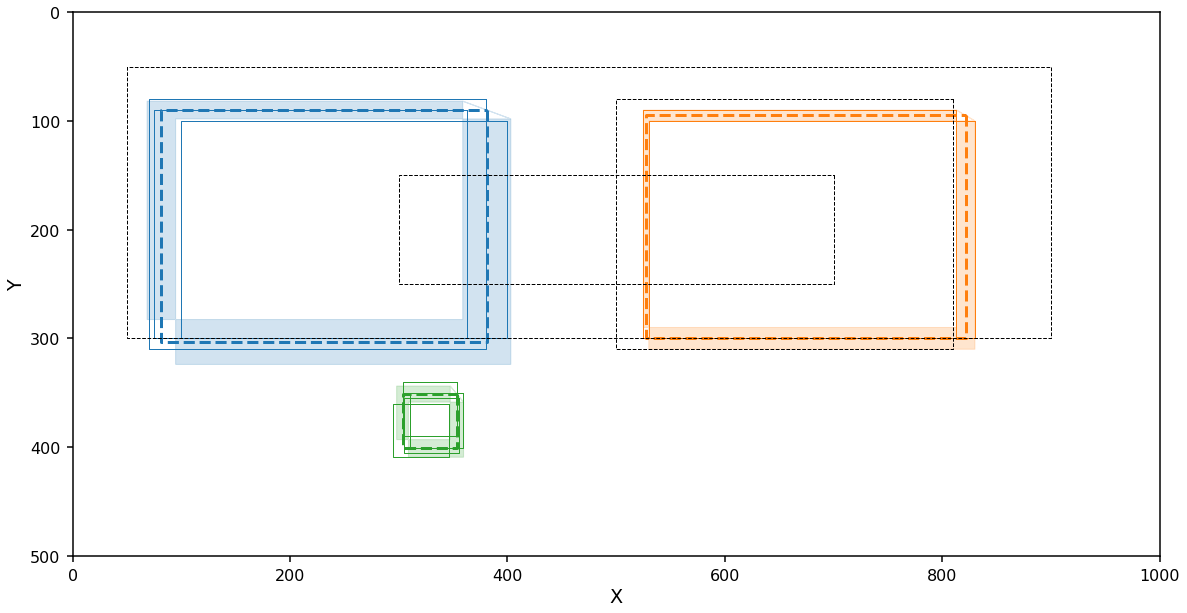

In [57]:
reduction = panoptes_aggregation.reducers.shape_reducer_dbscan(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    eps=35,
    min_samples=2,
    metric_type='euclidean'
)
plot_reduction(reduction)

Decent results, but the right cluster is a slightly different density and as a result one rectangle was left out if it.

#### Plotting note
When using the Euclidean based metric we need to calculate the confidence regions on each parameter independently, this makes it difficult to turn back into a region that can be plotted.  Because of this the upper right and lower left corners of this region are not shown in the plot above.  In actuality the shaded regions should be complete rectangles.

### OPTICS with Euclidean metric

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_optics:
        shape: rectangle
        min_samples: 2
        min_cluster_size: 2
```

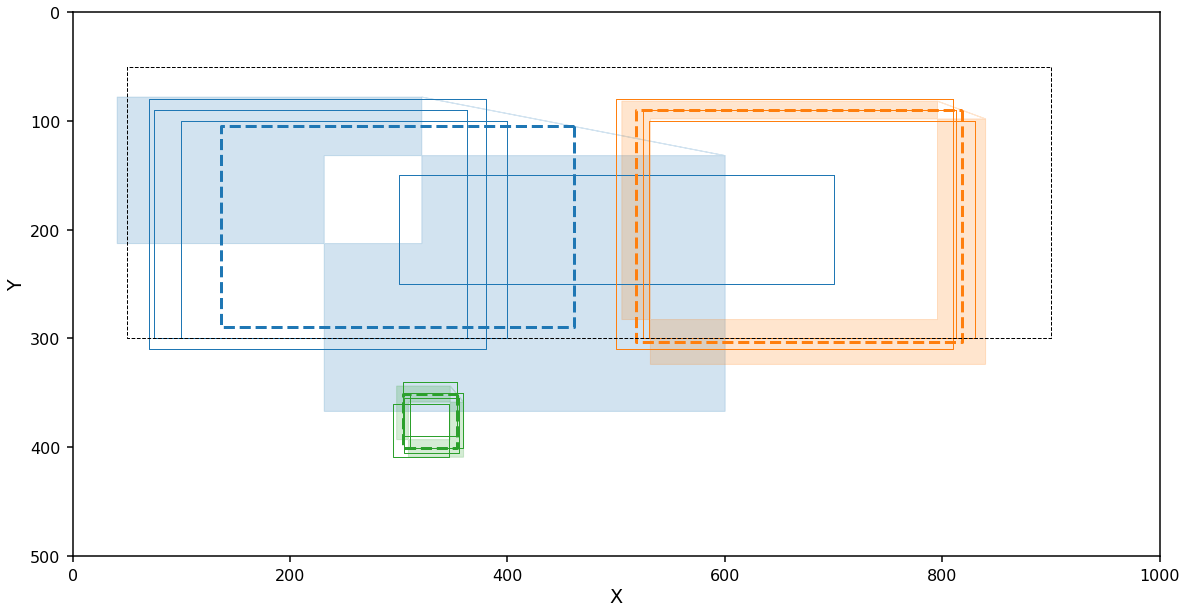

In [58]:
reduction = panoptes_aggregation.reducers.shape_reducer_optics(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    min_samples=2,
    min_cluster_size=2
)
plot_reduction(reduction)

The right cluster looks fine, but the left cluster is being interpreted as low density and including some of the noise.

### HDBSCAN with Euclidean metric

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_hdbscan:
        shape: rectangle
        min_samples: 2
        min_cluster_size: 2
```

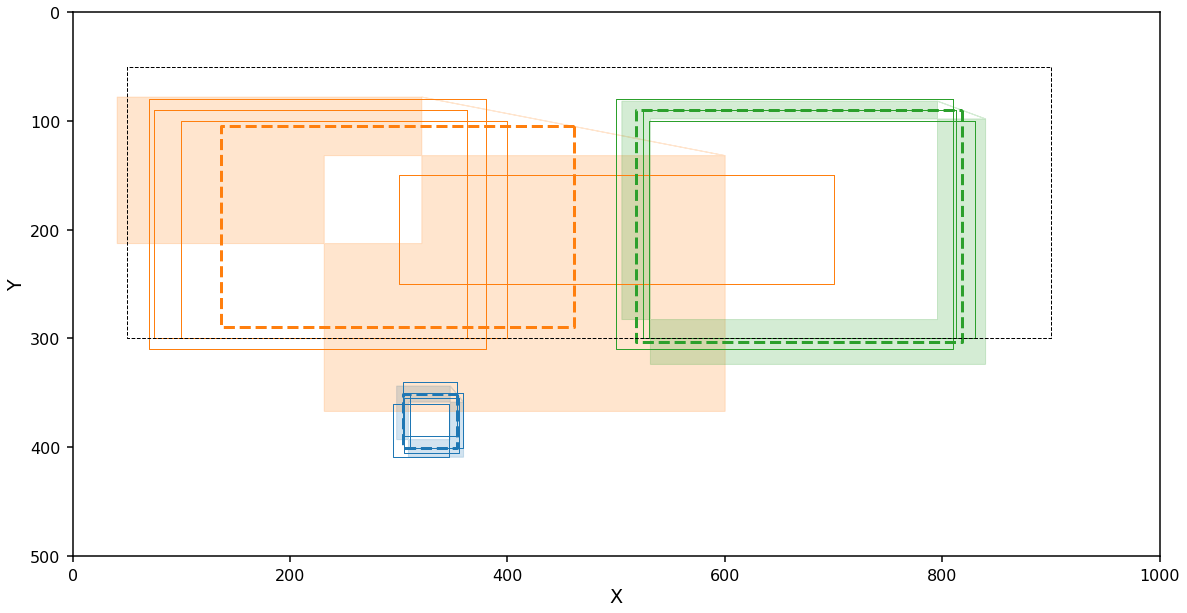

In [59]:
reduction = panoptes_aggregation.reducers.shape_reducer_hdbscan(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    min_samples=2,
    min_cluster_size=2
)
plot_reduction(reduction)

The exact same problem OPTICS has.

### DBSCAN with Jaccard metric

When using the Jaccard metric DBSCAN's $\epsilon$ has the units of metric (1 - percent overlap).  In practice setting to 0.5 works well in most cases.

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_dbscan:
        shape: rectangle
        eps: 0.5
        min_samples: 2
        metric_type: IoU
```

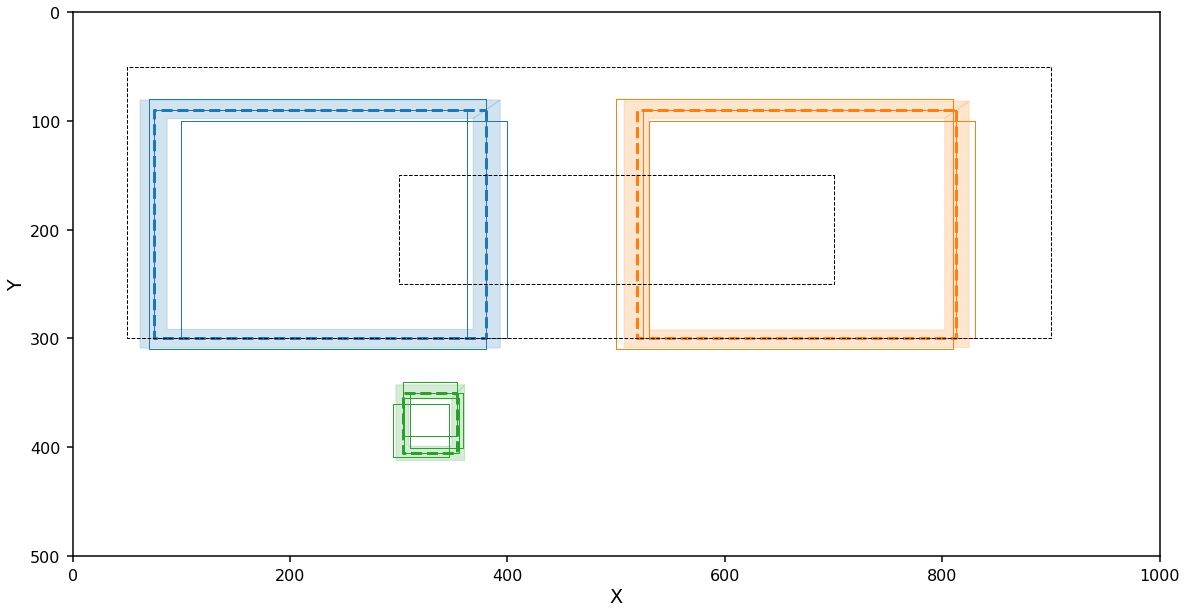

In [60]:
reduction = panoptes_aggregation.reducers.shape_reducer_dbscan(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    eps=0.5,
    min_samples=2,
    metric_type='IoU'
)
plot_reduction(reduction)

The Jaccard metric does a good job with all the clusters!

### OPTICS with Jaccard metric

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_optics:
        shape: rectangle
        min_samples: 2
        min_cluster_size: 2
        metric_type: IoU
```

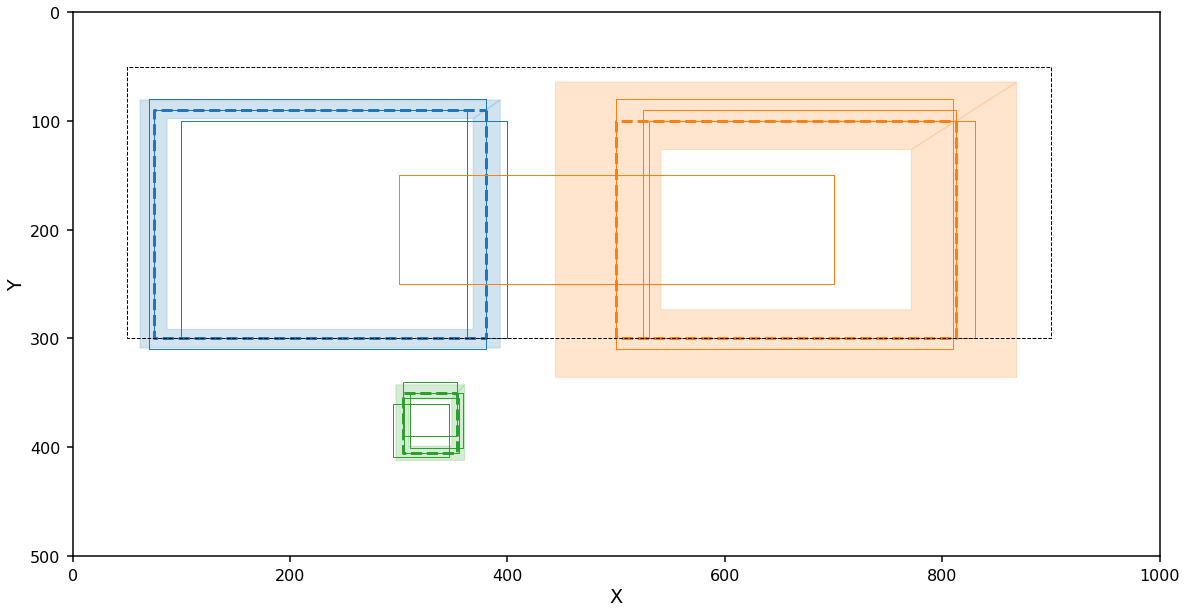

In [61]:
reduction = panoptes_aggregation.reducers.shape_reducer_optics(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    min_samples=2,
    min_cluster_size=2,
    metric_type='IoU'
)
plot_reduction(reduction)

This has the opposite problem as OPTICS with the Euclidean metric.  The left cluster looks fine, but the right cluster is picking up some noise.  This is likely caused by the nature of the Jaccard metric as it is only ranges form 0 to 1, causing partial overlaps on the edge of a cluster to be pulled into it.  But even with this noise included in the cluster, the mean and 1-$\sigma$ confidence region were not effected that much.

### HDBSCAN with Jaccard metric

The reducer config for this setup is

```yaml
reducer_config:
    shape_reducer_hdbscan:
        shape: rectangle
        min_samples: 2
        min_cluster_size: 2
        metric_type: IoU
```

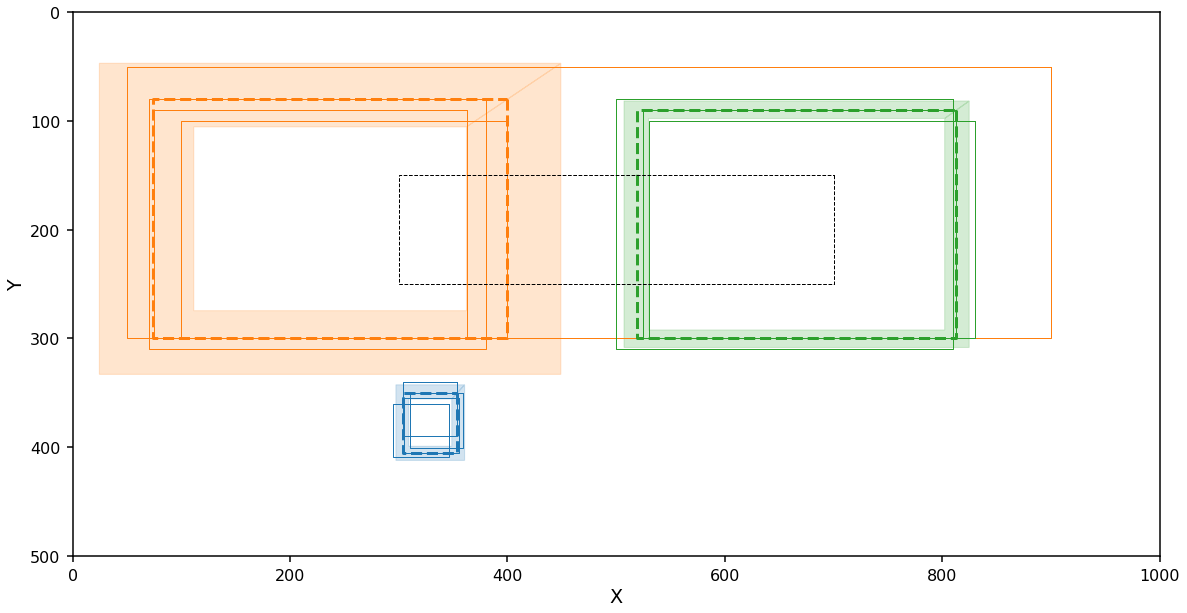

In [62]:
reduction = panoptes_aggregation.reducers.shape_reducer_hdbscan(
    extracted_data,
    user_id=user_id,
    shape='rectangle',
    min_samples=2,
    min_cluster_size=2,
    metric_type='IoU'
)
plot_reduction(reduction)

In the case of HDBSCAN with the Jaccard metric we see the left cluster picks up an additional rectangle that should be marked as noise, but as with OPTICS the resulting average rectangle and confidence region still look close to the true data.